In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import json, sys
from urllib import request
from copy import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Network Summary

## Network source and preprocesing

In [3]:
CLIENT_ID = 56337756
APP_ID = 7379264

Load friends data from VK

Drop deactivated accounts

Add my info to the network. Maybe it will be usefull

Saving data

Load data

In [4]:
with open('data/nodes_data.json','r') as f:
    nodes_data = json.load(f)
with open('data/connections_data.json','r') as f:
    connections_data = json.load(f)

Drop My data as it's happend to be useless

In [5]:
nodes_data = {k:v for k,v in nodes_data.items() if v['id']!=CLIENT_ID}
connections_data = {k:[v_ for v_ in v if v_!=CLIENT_ID] for k,v in connections_data.items() if k!=str(CLIENT_ID)}

Turn every node ID to string to prevent indexing mistakes

In [6]:
connections_data = {k: [v_ for v_ in v if str(v_) in connections_data.keys()]
                    for k,v in connections_data.items()}
nodes_data = {str(k):v for k,v in nodes_data.items()}
connections_data = {str(k):[str(v_) for v_ in v] for k,v in connections_data.items()}

In [7]:
G = nx.from_dict_of_lists(connections_data)

# Network Summary

## Run Gephi to create understandable layout

Firstly, define position of nodes in the graph

In [8]:
nx.write_gml(G, 'network.gml')

Load gephi graph and add info to it

In [9]:
G = nx.Graph(nx.read_gml('network_prettify_3.gml',))

In [10]:
for k,d in nodes_data.items():
    for k_, v_ in d.items():
        if k_ in ['id', 'first_name', 'last_name', 'city', 'university_name', 'faculty_name']:
            G.nodes[str(k)][k_] = v_

Getting _pos_ feature based on Gephi layout

In [11]:
for n in G.nodes:
    G.nodes[n]['pos'] = (G.nodes[n]['graphics']['x'], G.nodes[n]['graphics']['y'])
    if 'city' in G.nodes[n]:
        G.nodes[n]['city'] = G.nodes[n]['city']['title']

Prepare graph for plotly

In [12]:
nodelist = list(G.nodes)

pos = {n: (G.nodes[n]['graphics']['x'], G.nodes[n]['graphics']['y']) for n in nodelist}

dgrs = nx.degree(G)
sizes_by_degree = np.array([dgrs[n] for n in nodelist])
sizes_by_degree = np.log1p(sizes_by_degree/5)**3+7

colors_by_city = [{'Moscow':'orange', 'Izhevsk':'green'}.get(G.nodes[n]['city'], 'grey')
        if 'city' in G.nodes[n] else 'grey' for n in nodelist]

In [13]:
for n, x in zip(nodelist, sizes_by_degree):
    G.nodes[n]['size_by_degree'] = x

In [14]:
import plotly.graph_objects as go

## Node/Edge attributes

node attributes

In [15]:
G.nodes["779564"].keys()

dict_keys(['graphics', 'id', 'first_name', 'last_name', 'city', 'university_name', 'faculty_name', 'pos', 'size_by_degree'])

* id - ID пользователя ВК
* first_name - Имя
* last_name - Фамилия
* city - Город
* university_name - Университет
* faculty_name - Факультет
* pos - координата узла (создана в Gephi)
* graphics - данные от Gephi

edge attributes

In [16]:
G.edges[('779564','2661229')]

{'id': 3288, 'value': 1.0}

* id - номер ребра
* value - вес (= 1)

## Size, Order

In [17]:
print(f"Order of network: {len(G.nodes)}")
print(f"Size of network: {len(G.edges)}")

Order of network: 244
Size of network: 1657


## Gorgeous network layout

Code to plot graph using plotly

In [18]:
def plotly_graph(G, node_color, node_size, title=''):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=node_size,
            line_width=2
        )
    )
    
    node_text = [f"<br>".join([f"{k}: {v}" for k,v in G.nodes[n].items()
                               if k not in ['graphics','pos']]) for n in G.nodes]

    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title=title,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    return fig

In [19]:
fig = plotly_graph(G, node_color=colors_by_city, node_size=sizes_by_degree, title='Graph of friends by city (As example)')

![nodes_by_city](../imgs/nodes_by_city.png)

## Degree distribution
Diameter, Clustering Coefficient

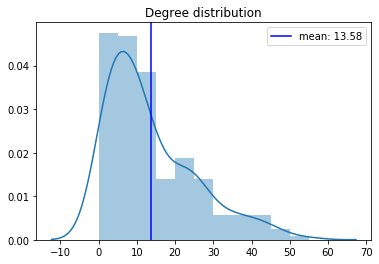

In [20]:
degrees = pd.Series(dict(nx.degree(G)))
sns.distplot(degrees)
plt.axvline(degrees.mean(), label=f"mean: {degrees.mean():.2f}", color='blue')
plt.legend()
plt.title('Degree distribution')
plt.show()

In [21]:
ccs_idxs = list(nx.connected_components(G))
ccs_idxs = sorted(ccs_idxs, key= lambda cc_idxs: -len(cc_idxs) )
ccs_Gs = [nx.subgraph(G, cc_idxs) for cc_idxs in ccs_idxs]

In [22]:
print(f"Number of connected components: {len(ccs_idxs)}")
print(f"Orders of connected components:", ', '.join([f"{len(cc_G.nodes())}" for cc_G in ccs_Gs]))
print(f"Sizes of connected components:", ', '.join([f"{len(cc_G.edges())}" for cc_G in ccs_Gs]))
print(f"Diameters of connected components:", ', '.join([f"{nx.diameter(cc_G)}" for cc_G in ccs_Gs]))

Number of connected components: 14
Orders of connected components: 155, 42, 28, 6, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1
Sizes of connected components: 1234, 318, 93, 7, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0
Diameters of connected components: 7, 5, 6, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0


In [23]:
print(f"Mean Clustering Coefficient: {nx.cluster.average_clustering(G):.4f}")
print(f'Clustering coefficients of Connected Components:',
      ', '.join([f"{nx.cluster.average_clustering(cc_G):.2f}" for cc_G in ccs_Gs]))

Mean Clustering Coefficient: 0.5712
Clustering coefficients of Connected Components: 0.55, 0.68, 0.73, 0.17, 0.83, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00


In [24]:
import pandas as pd

In [25]:
ccs_ds = pd.DataFrame()
ccs_ds['idxs'] = ccs_idxs
ccs_ds['subgraph'] = ccs_Gs
ccs_ds['order'] = ccs_ds['subgraph'].apply(lambda G: len(G.nodes))
ccs_ds['size'] = ccs_ds['subgraph'].apply(lambda G: len(G.edges))
ccs_ds['diameter'] = ccs_ds['subgraph'].apply(lambda G: nx.diameter(G))
ccs_ds['clustering_coef'] = ccs_ds['subgraph'].apply(lambda G: nx.cluster.average_clustering(G))

In [26]:
ccs_ds.head()

,idxs,subgraph,order,size,diameter,clustering_coef
0,"{416197567, 81158359, 17862450, 107025011, 900...","(779564, 1383897, 1950025, 2661229, 3217886, 4...",155,1234,7,0.554982
1,"{178908792, 45968439, 87811969, 31162482, 2892...","(178908792, 45968439, 87811969, 31162482, 2892...",42,318,5,0.676960
2,"{32582767, 268885442, 5191654, 49265157, 26099...","(32582767, 268885442, 5191654, 49265157, 26099...",28,93,6,0.734908
3,"{43048325, 42367477, 44200088, 72420610, 88113...","(43048325, 42367477, 44200088, 88113309, 72420...",6,7,3,0.166667
4,"{156070020, 94467180, 126150356, 135818294}","(156070020, 94467180, 126150356, 135818294)",4,5,2,0.833333


# Structural Analysis

## Degree/Closeness/Betweennes centralities
Top nodes interpretation

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
def get_degrees(G):
    return pd.Series(dict(nx.degree(G))).sort_values(ascending=False)

def get_degree_centrality(G):
    return pd.Series(dict(nx.degree_centrality(G))).sort_values(ascending=False)

def get_closeness_centr(G):
    return pd.Series(dict(nx.closeness_centrality(G))).sort_values(ascending=False)

def get_betweeness_centr(G):
    return pd.Series(nx.betweenness_centrality(G)).sort_values(ascending=False)

### Degree

In [29]:
en_degrees = get_degrees(G)
en_degree_centr = get_degree_centrality(G)

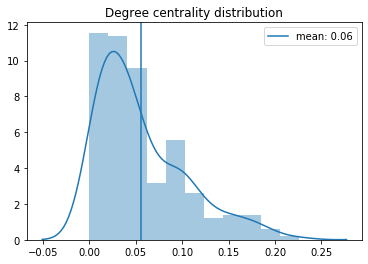

In [30]:
sns.distplot(en_degree_centr)
plt.title('Degree centrality distribution')
plt.axvline(en_degree_centr.mean(), label=f"mean: {en_degree_centr.mean():.2f}")
plt.legend()
plt.show()

In [31]:
for k,v in en_degree_centr.iteritems():
    G.nodes[k]['degree_centr'] = v

In [32]:
idx = 2
G.nodes[en_degree_centr.index[idx]], en_degree_centr.values[idx]*len(G.nodes), nx.degree(G)[en_degree_centr.index[idx]]

({'graphics': {'x': -560.88116,
   'y': -441.51453,
   'z': 0.0,
   'w': 10.0,
   'h': 10.0,
   'd': 10.0,
   'fill': '#94cc7d'},
  'id': 52128315,
  'first_name': 'Anastasia',
  'last_name': 'Nelidova',
  'city': 'Izhevsk',
  'university_name': 'ИжГТУ им. М. Т. Калашникова (бывш. ИМИ)',
  'faculty_name': 'Приборостроительный факультет',
  'pos': (-560.88116, -441.51453),
  'size_by_degree': 19.842590514079138,
  'degree_centr': 0.1934156378600823},
 47.193415637860085,
 47)

Nodes interpretation:
* 1) (55 mutual friends): Andrey Maximenko: One of Scout leaders from Izhevsk
* 2) (49 mutual friends): Tatyana Volnova: Other, more formal, Scout leader from Izhevsk
* 3) (47 mutual friends): Anastasia Nelidova: Connected with previous two

All are in the biggest connected component

### Closeness

In [33]:
en_closeness_centr = get_closeness_centr(G)

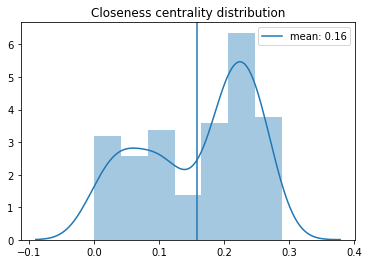

In [34]:
sns.distplot(en_closeness_centr)
plt.title('Closeness centrality distribution')
plt.axvline(en_closeness_centr.mean(), label=f"mean: {en_closeness_centr.mean():.2f}")
plt.legend()
plt.show()

In [35]:
for k,v in en_closeness_centr.iteritems():
    G.nodes[k]['closeness_centr'] = v

In [36]:
idx = 2
G.nodes[en_closeness_centr.index[idx]], np.mean(list(dict(nx.shortest_paths.shortest_path_length(G, en_closeness_centr.index[idx])).values()))

({'graphics': {'x': -560.88116,
   'y': -441.51453,
   'z': 0.0,
   'w': 10.0,
   'h': 10.0,
   'd': 10.0,
   'fill': '#94cc7d'},
  'id': 52128315,
  'first_name': 'Anastasia',
  'last_name': 'Nelidova',
  'city': 'Izhevsk',
  'university_name': 'ИжГТУ им. М. Т. Калашникова (бывш. ИМИ)',
  'faculty_name': 'Приборостроительный факультет',
  'pos': (-560.88116, -441.51453),
  'size_by_degree': 19.842590514079138,
  'degree_centr': 0.1934156378600823,
  'closeness_centr': 0.2741480556711518},
 2.296774193548387)

Nodes interpretation:
* 1) (2.18 handshakes) Natalya Bazhenova - A Scout leader who now works in my school
* 2) (2.23 handshakes) Irina "Metel" - A Scout leader who lives close to my school
* 3) (2.3 handshakes)  Anastasia Nelidova - Connected with previous two

### Betweeness

In [37]:
en_betweeness_centr = get_betweeness_centr(G)

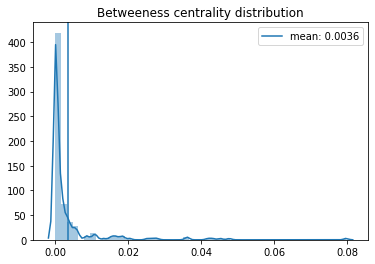

In [38]:
sns.distplot(en_betweeness_centr)
plt.title('Betweeness centrality distribution')
plt.axvline(en_betweeness_centr.mean(), label=f"mean: {en_betweeness_centr.mean():.4f}")
plt.legend()
plt.show()

In [39]:
for k,v in en_betweeness_centr.iteritems():
    G.nodes[k]['betweeness_centr'] = v

In [40]:
idx = 2
G.nodes[en_betweeness_centr.index[idx]], en_betweeness_centr.values[idx]

({'graphics': {'x': 35.87362,
   'y': -92.172775,
   'z': 0.0,
   'w': 10.0,
   'h': 10.0,
   'd': 10.0,
   'fill': '#94cc7d'},
  'id': 75721602,
  'first_name': 'Grisha',
  'last_name': 'Mukhachev',
  'city': 'Uva',
  'university_name': '',
  'faculty_name': '',
  'pos': (35.87362, -92.172775),
  'size_by_degree': 9.101745386768128,
  'degree_centr': 0.05349794238683128,
  'closeness_centr': 0.18073464410912973,
  'betweeness_centr': 0.045267795430744114},
 0.045267795430744114)

Nodes interpretation:
* 1) (8% smallest paths) - Svyatoslav Medvedev - played in a school orchestra, knows some of the family
* 2) (4.8% smallest paths) - Vladimir Reznikov - played in a school orchestra, has a blog
* 3) (4.5% smallest paths) - Grisha Mukhachev - family, knows Svyatoslav Medvedev

## Page-Rank. Comparison with centralities

In [41]:
pr = pd.Series(nx.pagerank(G, alpha=0.85)).sort_values(ascending=False)

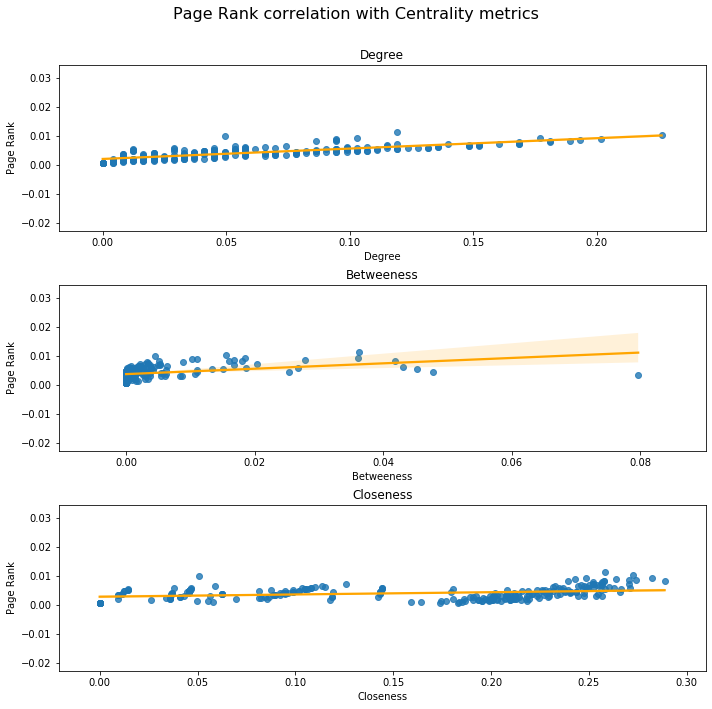

In [42]:
plt.figure(figsize=(10,10))
for idx, centr in enumerate([('Degree', en_degree_centr), ('Betweeness', en_betweeness_centr), ('Closeness', en_closeness_centr)]):
    plt.subplot(3,1,idx+1)
    title, centr = centr
    sns.regplot(x=centr.sort_index(), y=pr.sort_index(), line_kws={'color':'orange'})    
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel('Page Rank')
plt.tight_layout()
plt.suptitle('Page Rank correlation with Centrality metrics', size=16)
plt.subplots_adjust(top=0.9)
plt.show()

Page Rank highly correlates with Degree Centrality. It is expected since Page Rank favors nodes which have a lot of links, i.e. higher degree.

In [43]:
idx = 2
G.nodes[pr.index[idx]], pr.values[idx]

({'graphics': {'x': 103.67067,
   'y': -479.10315,
   'z': 0.0,
   'w': 10.0,
   'h': 10.0,
   'd': 10.0,
   'fill': '#94cc7d'},
  'id': 269933041,
  'first_name': 'Viktor',
  'last_name': 'Galushko',
  'city': 'Moscow',
  'university_name': 'УРИО (бывш. УРАО)',
  'faculty_name': '',
  'pos': (103.67067, -479.10315),
  'size_by_degree': 8.83275828030883,
  'degree_centr': 0.04938271604938272,
  'closeness_centr': 0.05084745762711864,
  'betweeness_centr': 0.00448366946683445},
 0.01013911568757412)

Nodes interpretation:
* 1) (1.13%) - Maxim Sterkhov - played in a school orchestra
* 2) (1.03%) - Andrey Maximenko - Scout leader
* 3) (1.01%) - Viktor Galushko - Head of Bauman Physical education class

## Assortative Mixing according to node attributes

In [44]:
pd.Series({attr: nx.assortativity.attribute_assortativity_coefficient(G, attr) for attr in ['city', 'university_name', 'faculty_name']})

city               0.210493
university_name    0.103921
faculty_name       0.078636
dtype: float64

## Node structural equivalence/similarity

In [45]:
import scipy.spatial as spt

In [46]:
def plotDist(A, figsize=(10,10)):
    f, ax = plt.subplots(2, 2, figsize=figsize)
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')

In [47]:
cm = list(nx.utils.reverse_cuthill_mckee_ordering(G))
A = nx.adjacency_matrix(G, nodelist=cm).todense()

/root/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide



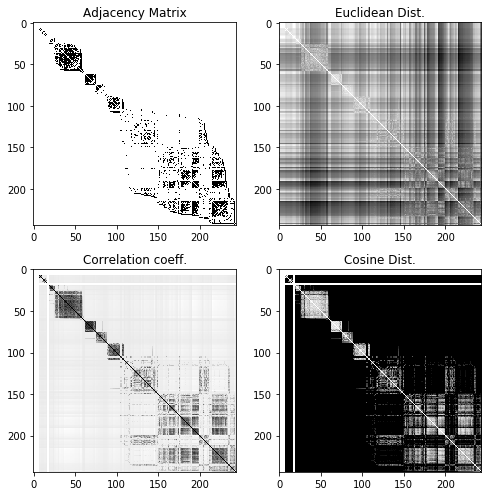

In [48]:
plotDist(A, figsize=(7,7))
plt.tight_layout()
plt.show()

## The closest random graph model similar to my SN

### Erdos-Renyi Graph model

$$ p = \frac{N_{edges}}{N_{possible\ edges}} $$
$$ N_{possible\ edges} = \frac{N_{nodes}(N_{nodes}-1)}{2} $$

In [49]:
n = len(G.nodes)
p = len(G.edges)/(n*(n-1)/2)
n, p

(244, 0.055892869189772654)

In [50]:
er_G = nx.erdos_renyi_graph(n, p)
er_degree_centr = get_degree_centrality(er_G)
er_closeness_centr = get_closeness_centr(er_G)
er_betweeness_centr = get_betweeness_centr(er_G)

### Preferential attachment

$$ N_{edges} = m(N_{nodes}-m) $$
$$ m^2 - N_{nodes}m + N_{edges} = 0 $$
$$ m = \frac{1}{2}\left(N_{nodes} \pm \sqrt{N_{nodes}^2-4N_{edges}} \right) $$

In [51]:
n = len(G.nodes)
m = (n-np.sqrt(n**2-4*len(G.edges)))/2
m = np.round(m).astype(int)
n, m

(244, 7)

In [52]:
ba_G = nx.barabasi_albert_graph(n, m)
ba_degree_centr = get_degree_centrality(ba_G)
ba_closeness_centr = get_closeness_centr(ba_G)
ba_betweeness_centr = get_betweeness_centr(ba_G)

In [53]:
len(ba_G.edges()), len(G.edges)

(1659, 1657)

### Small World

$$ N_{edges} = \frac{N_{nodes}*k}{2} $$
$$ k = \frac{2N_{edges}}{N_{nodes}} $$

In [54]:
n = len(G.nodes)
k = np.round(2*len(G.edges)/len(G.nodes)).astype(int)
n, k

(244, 14)

Choosing Probability of rewiring

In [55]:
ps = np.logspace(-6, 0, 101)
errors = []
for p in ps:
    centrs = [get_degree_centrality(nx.watts_strogatz_graph(n,k,p)) for i in range(10)]
          
    errors.append(np.mean([(centr.mean()-en_degree_centr.mean())**2 for centr in centrs]))

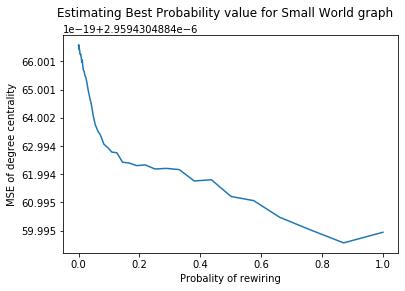

In [56]:
plt.plot(ps, errors)
plt.xlabel('Probality of rewiring')
plt.ylabel('MSE of degree centrality')
plt.suptitle('Estimating Best Probability value for Small World graph')
plt.show()

In [57]:
p = ps[np.argmin(errors)]
p

0.8709635899560796

In [58]:
ws_G = nx.watts_strogatz_graph(n, k, p)
ws_degree_centr = get_degree_centrality(ws_G)
ws_closeness_centr = get_closeness_centr(ws_G)
ws_betweeness_centr = get_betweeness_centr(ws_G)

In [59]:
len(ws_G.edges()), len(G.edges)

(1708, 1657)

## Combining Random Graph models

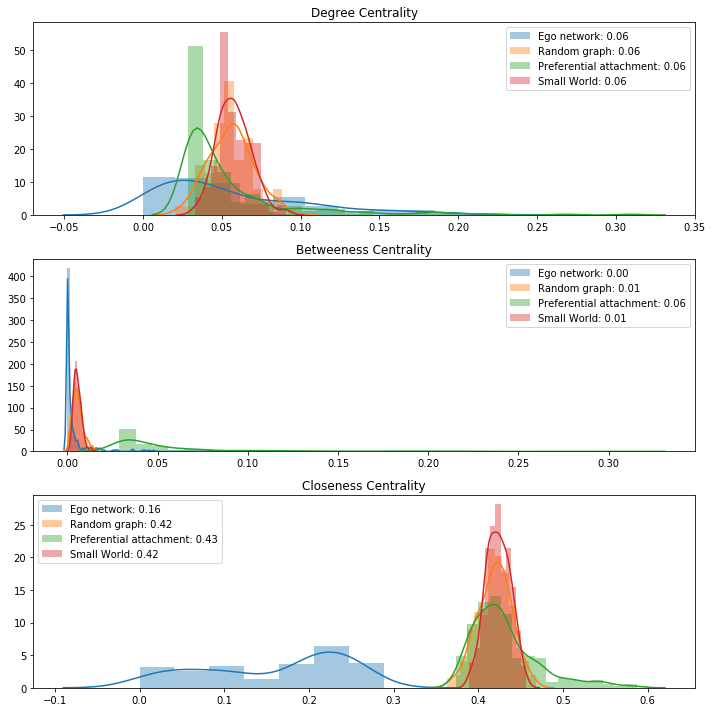

In [60]:
plt.figure(figsize=(10,10))
for idx, data in enumerate([(en_degree_centr, er_degree_centr, ba_degree_centr, ws_degree_centr, 'Degree Centrality'),
                             (en_betweeness_centr, er_betweeness_centr, ba_degree_centr, ws_betweeness_centr,  'Betweeness Centrality'),
                             (en_closeness_centr, er_closeness_centr, ba_closeness_centr, ws_closeness_centr, 'Closeness Centrality' )
                            ]):
    plt.subplot(3, 1, idx+1)
    for idx_, label in enumerate(['Ego network', 'Random graph', 'Preferential attachment', 'Small World',]):
        if data[idx_].var()>1e-10:
            sns.distplot(data[idx_], label=f'{label}: {data[idx_].mean():.2f}', kde=True)    
        else:
            sns.distplot(data[idx_], label=f'{label}: {data[idx_].mean():.2f}', kde=False)    
    plt.title(data[-1])
    plt.legend()
    

plt.tight_layout()
plt.show()

Choose best Random Graph model

In [61]:
rg_ds = pd.DataFrame(index=['Ego','Random graph', 'Preferential attachment', 'Small World'])
rg_ds['Degree'] = [x.median() for x in [en_degree_centr, er_degree_centr, ba_degree_centr, ws_degree_centr]]
rg_ds['Betweeness'] = [x.median() for x in [en_betweeness_centr, er_betweeness_centr, ba_betweeness_centr, ws_betweeness_centr]]
rg_ds['Closeness'] = [x.median() for x in [en_closeness_centr, er_closeness_centr, ba_closeness_centr, ws_closeness_centr]]
rg_ds

,Degree,Betweeness,Closeness
Ego,0.041152,0.000317,0.193645
Random graph,0.057613,0.005274,0.419689
Preferential attachment,0.041152,0.001881,0.423345
Small World,0.057613,0.005254,0.423345


In [62]:
rg_ds = (rg_ds-rg_ds.loc['Ego']).abs().rank()
rg_ds['Mean Rank'] = rg_ds.rank().mean(1)
rg_ds

,Degree,Betweeness,Closeness,Mean Rank
Ego,1.5,1.0,1.0,1.166667
Random graph,3.5,4.0,2.0,3.166667
Preferential attachment,1.5,2.0,3.5,2.333333
Small World,3.5,3.0,3.5,3.333333


No Random Graph is ideal for my network. In general Preferential attachment model gives better results.

# Community Detection

## Clique search

In [63]:
cliques = list(nx.find_cliques(G))

In [64]:
cliques = sorted(cliques, key=lambda x: -len(x))

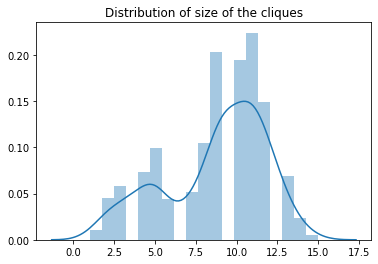

In [65]:
sns.distplot([len(x) for x in cliques])
plt.title('Distribution of size of the cliques')
plt.show()

People are actively communicate in groups of 5 and 10 persons. Which is coherent with the basic theory of amount of people in small in medium size teams.

## Best results of various community detection algorithms

In [66]:
def get_community_colors(com):
    #put all one-node communities to a single community
    one_node_comms = [c for c in com if len(c)==1]
    one_node_comms = frozenset([y for x in one_node_comms for y in x])
    com = [c for c in com if len(c)>1]+[one_node_comms]
    com = sorted(com, key=lambda x: -len(x))
    
    # get color index for every node
    colors_ = {x:idx for idx,c in enumerate(com) for x in c}
    colors_ = {x: colors_.get(x, len(set(colors_.values()))) for x in nodelist}

    # assign rgb color to node base on community
    palette = sns.color_palette(n_colors=len(set(colors_.values())))
    palette = ['rgb('+','.join([f"{int(x*255)}" for x in c])+')' for c in palette]
    colors_ = [palette[colors_[n]] for n in nodelist]
    return com, colors_

### k-clique

In [67]:
com_kclique = list(nx.community.k_clique_communities(G, 3))
com_kclique, colors_ = get_community_colors(com_kclique)

![kclique](../imgs/kclique_comunity.png)

In [68]:
d = {n:idx for idx, c in enumerate(com_kclique) for n in c}
for n in G.nodes:
    G.nodes[n]['k-clique'] = d.get(n, max(d.values())+1)

### Modularity based

In [69]:
com_mod = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
com_mod, colors_ = get_community_colors(com_mod)

![mod_comunity](../imgs/modularity_based_comunity.png)

In [70]:
d = {n:idx for idx, c in enumerate(com_mod) for n in c}
for n in G.nodes:
    G.nodes[n]['Modularity based community'] = d.get(n, max(d.values())+1)

### Girvan-Newman

In [71]:
from tqdm.notebook import tqdm

In [72]:
from itertools import islice

In [73]:
com_gns = [c for c in islice(nx.algorithms.community.centrality.girvan_newman(G), 5)]

In [74]:
com_gn = com_gns[3]

In [75]:
com_gn, colors_ = get_community_colors(com_gn)

![girvan_newman](../imgs/girvan_newman_comunity.png)

In [76]:
d = {n:idx for idx, c in enumerate(com_gn) for n in c}
for n in G.nodes:
    G.nodes[n]['Girvan-Newman community'] = d.get(n, max(d.values())+1)

In [77]:
d_ = {0: 'Scouts',
 1: 'School',
 2: 'BMSTU',
 3: 'Family',
 4: 'BMSTU Orchestra',
 5: 'BMSTU Physical Education',
 6: 'No mutual friends',
 7: 'HSE',
 8: 'Summer Camp',
 9: 'Summer Camp 2'}
for n in G.nodes:
    G.nodes[n]['Community'] = d_[d[n]]

## Incremental algorithms presented during classes

In [78]:
def MCL(A, tol, p, alpha):
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums[np.newaxis, :]
    M = T
    M = np.nan_to_num(M)
    while(1):
        step += 1
        # Expancion step:
        M1 = np.linalg.matrix_power(M, p)
        # Inflation step:
        M1 = np.power(M1, alpha)
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums[np.newaxis, :]
        M1 = np.nan_to_num(M1)
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:
            return M1
        else:
            M = M1.copy()

In [79]:
def MCL_communities(A, tol, p, alpha, cm):
    M = MCL(np.array(A), tol, p, alpha)

    com_mcl = []
    for idx, n in enumerate(cm):
        if M[idx].sum()>0:
            com = set([n]+[cm[idx_] for idx_,v in enumerate(M[idx]) if v==1])
            com_mcl.append(frozenset(com))
    return com_mcl

In [80]:
cm = list(nx.utils.reverse_cuthill_mckee_ordering(G))
A = nx.adjacency_matrix(G, nodelist=cm).todense()

Empiricaly find the best tolerance value

In [81]:
tols = list(np.linspace(0.00001, 1, 100))
com_lens = []
for t in tqdm(tols):
    com_mcl = MCL_communities(A, t, 2, 2, cm)
    com_mcl, colors_ = get_community_colors(com_mcl)
    com_lens.append(len(com_mcl))
com_lens = np.array(com_lens)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in true_divide



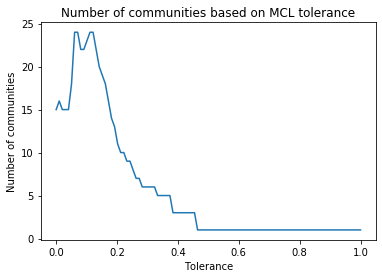

In [82]:
plt.plot(tols, com_lens)
plt.title('Number of communities based on MCL tolerance')
plt.xlabel('Tolerance')
plt.ylabel('Number of communities')
plt.show()

In [83]:
t = tols[np.argmax(com_lens==3)]

In [84]:
com_mcl = MCL_communities(A, t, 2, 2, cm)
com_mcl, colors_ = get_community_colors(com_mcl)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in true_divide



In [85]:
d = {n:idx for idx, c in enumerate(com_mcl) for n in c}
for n in G.nodes:
    G.nodes[n]['MCL community'] = d.get(n, max(d.values())+1)

# Save model for Gephi visualization

In [86]:
G_fin = G.copy()
for n in G_fin.nodes:
    del G_fin.nodes[n]['pos']

In [87]:
nx.write_gexf(G_fin, 'graph_final.gexf')